In [2]:
from langchain_groq import ChatGroq
llm_groq = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
llm_groq.invoke("Hello, how are you?").content


"Hello. I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you might have. How can I assist you today?"

In [4]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [10]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_groq.invoke(messages)
    return {"messages": [response]}

In [11]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

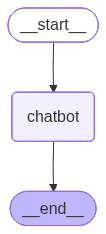

In [12]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
input={"messages":["hi, my name is Ani"]}

In [16]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is Ani', additional_kwargs={}, response_metadata={}, id='3c316664-8cff-4aad-8509-92b4d7a21334'),
  AIMessage(content="Hello Ani! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 42, 'total_tokens': 69, 'completion_time': 0.045163711, 'prompt_time': 0.002628809, 'queue_time': 0.27789691, 'total_time': 0.04779252}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_55062f05af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b4465dd8-462a-461e-8ac5-2a231482bd4f-0', usage_metadata={'input_tokens': 42, 'output_tokens': 27, 'total_tokens': 69})]}

In [17]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Ani! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 42, 'total_tokens': 69, 'completion_time': 0.044028725, 'prompt_time': 0.002400377, 'queue_time': 0.295877163, 'total_time': 0.046429102}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4d4005649c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--21aded9b-df87-4741-874e-8ea229de58a6-0', usage_metadata={'input_tokens': 42, 'output_tokens': 27, 'total_tokens': 69})]}




In [42]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

TypeError: 'list' object is not callable

In [19]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [20]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [21]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001FB14327740>)

In [23]:
tools=[search]

In [24]:
tool_node=ToolNode(tools)

In [25]:

llm_with_tool=llm_groq.bind_tools(tools)

In [26]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [27]:
response=call_model({"messages": ["hi how are you?"]})

In [28]:
response

{'messages': [AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 213, 'total_tokens': 238, 'completion_time': 0.063074428, 'prompt_time': 0.015348362, 'queue_time': 0.281870327, 'total_time': 0.07842279}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_21854da540', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ae0824cf-e8ed-453f-a7ce-7bcc1dc17fbb-0', usage_metadata={'input_tokens': 213, 'output_tokens': 25, 'total_tokens': 238})]}

In [32]:
response=call_model({"messages": ["what is a weather in India?"]})

In [33]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0bcvsg9x9', 'function': {'arguments': '{"query":"India weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 215, 'total_tokens': 229, 'completion_time': 0.060600323, 'prompt_time': 0.013184012, 'queue_time': 0.056875417, 'total_time': 0.073784335}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e1b9f8e5-00a5-4758-984b-e44a8c23e2dd-0', tool_calls=[{'name': 'search', 'args': {'query': 'India weather'}, 'id': '0bcvsg9x9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 215, 'output_tokens': 14, 'total_tokens': 229})]}

In [34]:
messages = response['messages']

In [35]:
last_message=messages[-1]

In [36]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'India weather'},
  'id': '0bcvsg9x9',
  'type': 'tool_call'}]

In [37]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [38]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

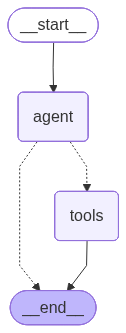

In [39]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='8cfc7710-79c0-41c3-86a0-fa6abe35e4bb'),
  AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 213, 'total_tokens': 238, 'completion_time': 0.065361983, 'prompt_time': 0.017125971, 'queue_time': 0.283916518, 'total_time': 0.082487954}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3867538541', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--e4600843-0d6c-4dcb-95c5-d32975e65a4e-0', usage_metadata={'input_tokens': 213, 'output_tokens': 25, 'total_tokens': 238})]}

In [41]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='f5a62e44-29b1-4fd5-b260-aeb42c9a490e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xntwed0ks', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.055604163, 'prompt_time': 0.031930758, 'queue_time': 0.283465572, 'total_time': 0.087534921}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_a7161653a1', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d9b037ce-e555-4233-b38c-f0134aa69596-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'xntwed0ks', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229}),
  ToolMessage(content="It's 60 degrees a